# Ensembling

In [1]:
from sklearn import metrics, svm, linear_model, ensemble
import optunity

import matplotlib.pyplot as plt

import optunity
import optunity.metrics
import numpy as np

# k nearest neighbours
from sklearn.neighbors import KNeighborsClassifier
# support vector machine classifier
from sklearn.svm import SVC
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
# Random Forest
from sklearn.ensemble import RandomForestClassifier

## Loading all the data

In [2]:
X_train = np.load("X_train2.npy")
X_valid = np.load("X_valid2.npy")
X_test = np.load("X_test2.npy")

Y_train = np.load("Y_train2.npy")
Y_valid = np.load("Y_valid2.npy")
filenames = np.load("filenames_test2.npy")

Making the data for optunity

In [3]:
data = np.concatenate((X_train, X_valid))
labels = np.concatenate((Y_train, Y_valid))

data.shape, labels.shape

((2295, 3), (2295,))

## Training and optimizing

In [4]:
def roc_score(model, X_valid, Y_valid):
    return metrics.roc_auc_score(Y_valid, model.predict(X_valid))

In [5]:
LogReg = linear_model.LogisticRegression()

SVM = svm.SVC(C = 0.5)

LinSVC = svm.LinearSVC(C = 0.5)

In [116]:
LogReg.C = 0.5

In [117]:
LogReg.C

0.5

In [118]:
LogReg.fit(X_train, Y_train)
SVM.fit(X_train, Y_train)
LinSVC.fit(X_train, Y_train)

LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [22]:
def find_C(model_init, X_train, Y_train, X_valid, Y_valid, C = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1] , plot = True):
    roc = []
    for i in range(len(C)):
        model = model_init
        model.C = C[i]
        model.fit(X_train, Y_train)
        
        roc.append(roc_score(model, X_valid, Y_valid))
    if plot: 
        plt.plot(C, roc)
        plt.xlabel("C value")
        plt.ylabel("AUC ROC score")
        plt.show()
    return C, roc

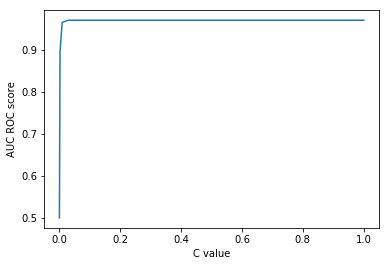

[0.5,
 0.89500000000000002,
 0.96499999999999997,
 0.96999999999999997,
 0.96999999999999997,
 0.96999999999999997,
 0.96999999999999997]

In [24]:
C_linreg, roc_linreg = find_C(linear_model.LogisticRegression(), X_train, Y_train, X_valid, Y_valid )
roc_linreg

## Using Optunity to optimize the classifier

In [6]:
def train_svm(data, labels, kernel, C, gamma, degree, coef0):
    """A generic SVM training function, with arguments based on the chosen kernel."""
    if kernel == 'linear':
        model = SVC(kernel=kernel, C=C)
    elif kernel == 'poly':
        model = SVC(kernel=kernel, C=C, degree=degree, coef0=coef0)
    elif kernel == 'rbf':
        model = SVC(kernel=kernel, C=C, gamma=gamma)
    else:
        raise ArgumentError("Unknown kernel function: %s" % kernel)
    model.fit(data, labels)
    return model

In [7]:
search = {'algorithm': {'k-nn': {'n_neighbors': [1, 5]},
                        'SVM': {'kernel': {'linear': {'C': [0, 2]},
                                           'rbf': {'gamma': [0, 1], 'C': [0, 10]},
                                           'poly': {'degree': [2, 5], 'C': [0, 50], 'coef0': [0, 1]}
                                           }
                                },
                        'naive-bayes': None,
                        #'random-forest': {'n_estimators': [10, 30],
                        #                  'max_features': [0, 20.0]}
                        }
         }

In [8]:
@optunity.cross_validated(x=data, y=labels, num_folds=5)
def performance(x_train, y_train, x_test, y_test,
                algorithm, n_neighbors=None, n_estimators=None, max_features=None,
                kernel=None, C=None, gamma=None, degree=None, coef0=None):
    # fit the model
    if algorithm == 'k-nn':
        model = KNeighborsClassifier(n_neighbors=int(n_neighbors))
        model.fit(x_train, y_train)
    elif algorithm == 'SVM':
        model = train_svm(x_train, y_train, kernel, C, gamma, degree, coef0)
    elif algorithm == 'naive-bayes':
        model = GaussianNB()
        model.fit(x_train, y_train)
    elif algorithm == 'random-forest':
        model = RandomForestClassifier(n_estimators=int(n_estimators),
                                       max_features=int(max_features))
        model.fit(x_train, y_train)
    else:
        raise ArgumentError('Unknown algorithm: %s' % algorithm)

    # predict the test set
    if algorithm == 'SVM':
        predictions = model.decision_function(x_test)
    else:
        predictions = model.predict_proba(x_test)[:, 1]

    return optunity.metrics.roc_auc(y_test, predictions, positive=True)

In [9]:
performance(x_train = X_train, y_train = Y_train, 
            x_test = X_valid,  y_test = Y_valid, algorithm='k-nn', n_neighbors=3)

0.9930369274377984

In [32]:
optimal_configuration, info, sug = optunity.maximize_structured(performance,
                                                              search_space=search,
                                                              num_evals=300)

In [33]:
sug

{'algorithm': [0.0, 3.0],
 'algorithm|SVM|kernel': [0.0, 3.0],
 'algorithm|SVM|kernel|linear|C': [0, 2],
 'algorithm|SVM|kernel|poly|C': [0, 50],
 'algorithm|SVM|kernel|poly|coef0': [0, 1],
 'algorithm|SVM|kernel|poly|degree': [2, 5],
 'algorithm|SVM|kernel|rbf|C': [0, 10],
 'algorithm|SVM|kernel|rbf|gamma': [0, 1],
 'algorithm|k-nn|n_neighbors': [1, 5],
 'num_generations': 15,
 'num_particles': 20,
 'solver_name': 'particle swarm'}

In [35]:
solution = dict([(k, v) for k, v in optimal_configuration.items() if v is not None])
print('Solution\n========')
print("\n".join(map(lambda x: "%s \t %s" % (x[0], str(x[1])), solution.items())))

Solution
kernel 	 poly
C 	 33.7897135417
coef0 	 0.522399215087
degree 	 2.70070937083
algorithm 	 SVM


In [36]:
print(optimal_configuration)
print(info.optimum)

{'kernel': 'poly', 'C': 33.78971354166666, 'algorithm': 'SVM', 'degree': 2.7007093708339083, 'n_neighbors': None, 'coef0': 0.5223992150867972, 'gamma': None}
0.998286413492


## Training on the data

In [37]:
SVM = svm.SVC( kernel = optimal_configuration['kernel'], C =  optimal_configuration['C'], 
              coef0 = optimal_configuration['coef0'], 
             degree = optimal_configuration['degree']      
             )

In [38]:
SVM.fit(X_train, Y_train)

SVC(C=33.7897135417, cache_size=200, class_weight=None, coef0=0.522399215087,
  decision_function_shape=None, degree=2.70070937083, gamma='auto',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [39]:
preds = SVM.predict(X_test)

In [40]:
preds2 = SVM.decision_function(X_test)

In [41]:
valid = SVM.predict(X_valid)

In [42]:
valid2 = SVM.decision_function(X_valid)

In [45]:
metrics.roc_auc_score(Y_valid,valid2)

0.98659999999999992

In [19]:
np.array_equal(preds, preds2)

False

In [20]:
ids = [int(f[5:f.find('.')]) for f in filenames]
combined2 = np.column_stack((ids, preds2))

In [21]:
np.savetxt("inv3.csv", combined2, fmt="%d,%.5f", header = 'name,invasive')